## **Importacion de Librerias**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 
import random
import seaborn as sns
import PIL
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK

from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## **Extraccion del Dataset**

In [2]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (660/660), done.


In [3]:
sld_dir = pathlib.Path('Sign-Language-Digits-Dataset/Dataset/')
print(len(list(sld_dir.glob('*/*.JPG'))))

2062


## **Division del Dataset**

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  sld_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2062 files belonging to 10 classes.
Using 1650 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  sld_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2062 files belonging to 10 classes.
Using 412 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## **Comprobacion y Muestreo de los Datos**

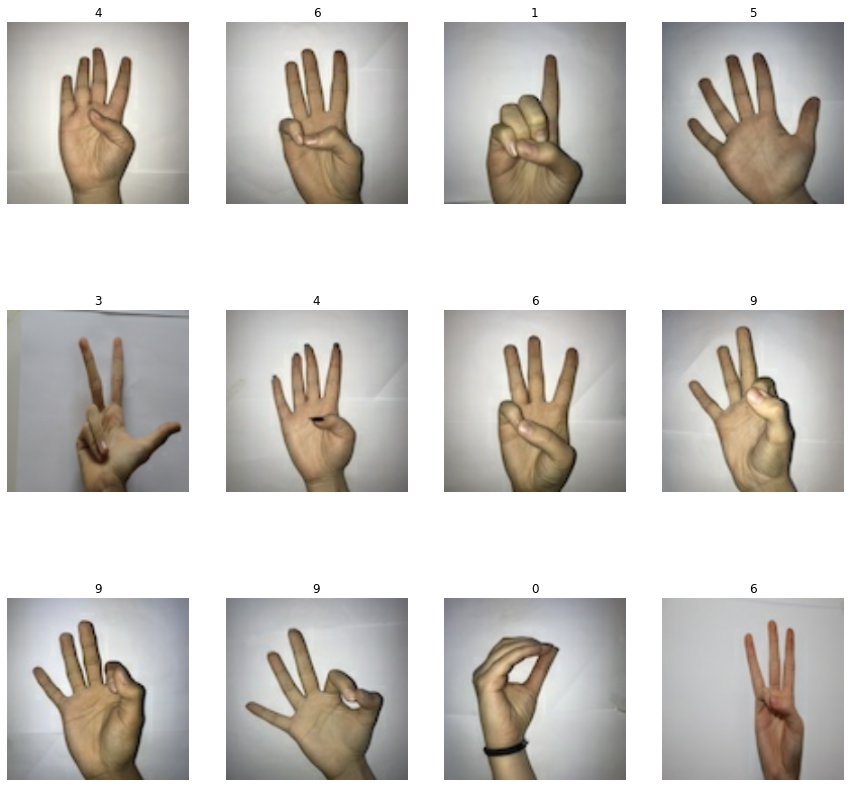

In [8]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## **Normalizacion de los Datos**

In [9]:
normalization_layer = layers.Rescaling(1./255)

train_ds_nm = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_nm))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1.7220174e-06 0.98257095


In [10]:
test_ds_nm = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(test_ds_nm))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.03771349 0.9999999


## **Carga de Funciones Esenciales**

In [11]:
def cargar_imagen(folder):
  train = {}
  test = {}
  count = 0
  for foldername in os.listdir(folder):
    categoria1=[]
    categoria2=[]
    count = 0 
    ruta = folder + '/' + foldername 
    for filename in os.listdir(ruta):
      img = cv2.imread(ruta + '/' + filename, cv2.IMREAD_GRAYSCALE)
      count += 1
      if img is not None:
        if count <= int(0.8*len(os.listdir(ruta))):
          categoria1.append(img)
        else:
          categoria2.append(img)

    train[foldername] = categoria1
    test[foldername] = categoria2

  return train,test

def sift_feat(imagenes):
  sift = cv2.SIFT_create()
  sift_featXcat = {}
  sift_feat_all = []
  for key, value in imagenes.items():
    featXcat = []
    for img in value:
      kp,desc = sift.detectAndCompute(img, None)
      sift_feat_all.extend(desc)
      featXcat.append(desc)
    sift_featXcat[key] = featXcat
  return [sift_feat_all, sift_featXcat]

def kmeans(k,lista):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(lista)
  visual_words = kmeans.cluster_centers_
  return visual_words

def find_idx(feat,center):
  count=0
  ind=0
  for i in range(len(center)):
    if(i==0):
      count = distance.euclidean(feat,center[i])
    else:
      dist = distance.euclidean(feat,center[i])
      if (dist<count):
        ind = i
        count = dist
    return ind

def img_clases(bovw_feat,centers):
  dict_feat = {}
  for key, value in bovw_feat.items():
    imagens = []
    for img in value:
      histo = np.zeros(len(centers))
      for each_feat in img:
        idx = find_idx(each_feat,centers)
        histo[idx] += 1
      imagens.append(histo)
    dict_feat[key] = imagens
  return dict_feat

def preparar_datos(diccio):
  y=[]
  x=[]
  for key, values in diccio.items():
    for histo in values:
      x.append(histo)
      y.append(key)
  return np.array(x), np.array(y)

## **Modelo Tradicional**

### **Extraccion de Datos Modelo Tradicional**

In [12]:
x_train_cnn= []
y_train_cnn= []
for images, labels in train_ds.take(51):
  for i in range(32):
    x_train_cnn.append(images[i].numpy().astype("uint8"))
    y_train_cnn.append(class_names[labels[i]])

In [13]:
print(np.asarray(x_train_cnn).shape)
print(np.asarray(y_train_cnn).shape)

(1632, 180, 180, 3)
(1632,)


In [14]:
x_test_cnn= []
y_test_cnn= []
for images2, labels2 in val_ds.take(12):
  for i in range(32):
    x_test_cnn.append(images2[i].numpy().astype("uint8"))
    y_test_cnn.append(class_names[labels2[i]])

In [15]:
print(np.asarray(x_test_cnn).shape)
print(np.asarray(y_test_cnn).shape)

(384, 180, 180, 3)
(384,)


In [16]:
train_TDC = {}
for i in range(0,10):
  datos=[]
  for indice, valor in enumerate(y_train_cnn):
    if int(valor) == i:
       datos.append(x_train_cnn[indice])
  train_TDC[i] = datos

In [17]:
print(train_TDC.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [18]:
test_TDC = {}
for i in range(0,10):
  datos=[]
  for indice, valor in enumerate(y_test_cnn):
    if int(valor) == i:
       datos.append(x_test_cnn[indice])
  test_TDC[i] = datos

In [19]:
print(test_TDC.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


### **Extracion de Caracteristicas**

In [20]:
sifts = sift_feat(train_TDC)

feat_all = sifts[0]
train_bovw_feat = sifts[1] 

In [21]:
test_bovw_feat = sift_feat(test_TDC)[1]

### **Creacion Bolsa de Palabras Visuales**

In [22]:
visual_words = kmeans(100,feat_all)
print(visual_words.shape)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(100, 128)


### **Creacion de los Histogramas y Preparacion de los Datos a la Entrada de la Red**

In [23]:
bovw_train = img_clases(train_bovw_feat, visual_words)
x_train, y_train = preparar_datos(bovw_train)

In [24]:
print(x_train.shape)
print(y_train.shape)

(1632, 100)
(1632,)


In [25]:
bovw_test = img_clases(test_bovw_feat,visual_words)
x_test, y_test = preparar_datos(bovw_test)

In [26]:
print(x_test.shape)
print(y_test.shape)

(384, 100)
(384,)


### **Normalizacion Datos Modelo Tradicional**

In [27]:
std = StandardScaler().fit(x_train)
x_train = std.transform(x_train)
x_test = std.transform(x_test)

### **Creacion Red MLP de Clasificacion y Entrenamiento**

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=(80,5), activation='relu', solver='adam', max_iter=500 )
MLP_fit = mlp.fit(x_train,y_train,)

### **Validacion del Modelo Tradicional**

#### **Matriz de Confucion**

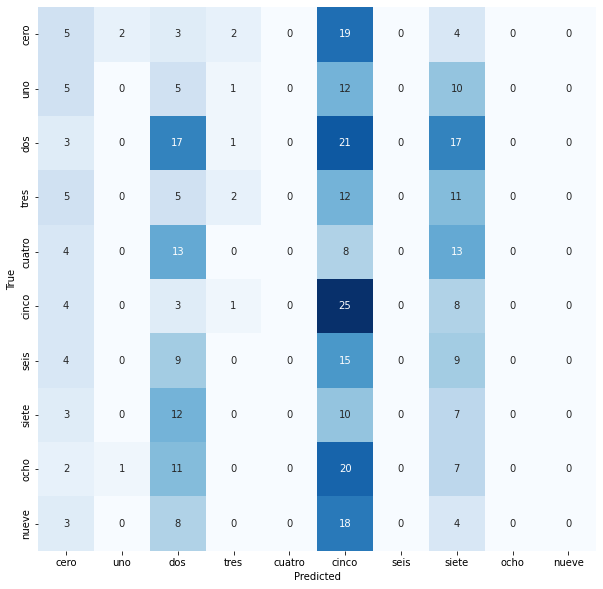

In [29]:
y_pred = mlp.predict(x_test)
cm = confusion_matrix(y_test,y_pred, labels=mlp.classes_)
labels_cm=['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']

plt.figure(figsize=(10,10))
sns.heatmap(cm,cbar=False,xticklabels=labels_cm,yticklabels=labels_cm,fmt='d',annot=True,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Reporte Metricas del Modelo Tradicioanl**

In [61]:
print(classification_report(y_test,y_pred, target_names=labels_cm))

              precision    recall  f1-score   support

        cero       0.13      0.14      0.14        35
         uno       0.00      0.00      0.00        33
         dos       0.20      0.29      0.23        59
        tres       0.29      0.06      0.10        35
      cuatro       0.00      0.00      0.00        38
       cinco       0.16      0.61      0.25        41
        seis       0.00      0.00      0.00        37
       siete       0.08      0.22      0.11        32
        ocho       0.00      0.00      0.00        41
       nueve       0.00      0.00      0.00        33

    accuracy                           0.15       384
   macro avg       0.08      0.13      0.08       384
weighted avg       0.09      0.15      0.09       384



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Modelo CNN**

### **Creacion de la Arquitectura de la Red**

In [50]:
entrada = LK.Input(shape=(180,180,3))
conv1 = LK.Conv2D(6,5,padding='same',activation = 'relu')(entrada)
pool1 = LK.MaxPool2D((2,2),(2,2))(conv1)
conv2 = LK.Conv2D(16,5,padding='valid', activation = 'relu')(pool1)
pool2 = LK.MaxPool2D((2,2),(2,2))(conv2)
flat = LK.Flatten()(pool2)
fc1 = LK.Dense(120,activation='relu')(flat)
fc2 = LK.Dense(84,activation='relu')(fc1)
salida = LK.Dense(10,activation='sigmoid')(fc2)
lenet = MK.Model(entrada,salida)

lenet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 6)       456       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 86, 86, 16)        2416      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 29584)             0   

### **Definicion de los Hyperparametros de la Red**

In [51]:
lenet.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

### **Entrenamiento del Modelo CNN**

In [52]:
epochs=20
history = lenet.fit(train_ds_nm,validation_data=test_ds_nm,epochs=epochs)

Epoch 1/20
52/52 [==============================] - 4s 35ms/step - loss: 2.6040 - accuracy: 0.1521 - val_loss: 2.1394 - val_accuracy: 0.3228
Epoch 2/20
52/52 [==============================] - 2s 32ms/step - loss: 1.7455 - accuracy: 0.4194 - val_loss: 1.3637 - val_accuracy: 0.6165
Epoch 3/20
52/52 [==============================] - 2s 32ms/step - loss: 0.8037 - accuracy: 0.7576 - val_loss: 0.8128 - val_accuracy: 0.7257
Epoch 4/20
52/52 [==============================] - 3s 51ms/step - loss: 0.3973 - accuracy: 0.8782 - val_loss: 0.6304 - val_accuracy: 0.8204
Epoch 5/20
52/52 [==============================] - 3s 59ms/step - loss: 0.2496 - accuracy: 0.9255 - val_loss: 0.5167 - val_accuracy: 0.8422
Epoch 6/20
52/52 [==============================] - 2s 43ms/step - loss: 0.1659 - accuracy: 0.9521 - val_loss: 0.5519 - val_accuracy: 0.8544
Epoch 7/20
52/52 [==============================] - 2s 39ms/step - loss: 0.0994 - accuracy: 0.9752 - val_loss: 0.5938 - val_accuracy: 0.8447
Epoch 8/20
52

### **Graficos Accuracy y Loss del Modelo CNN**

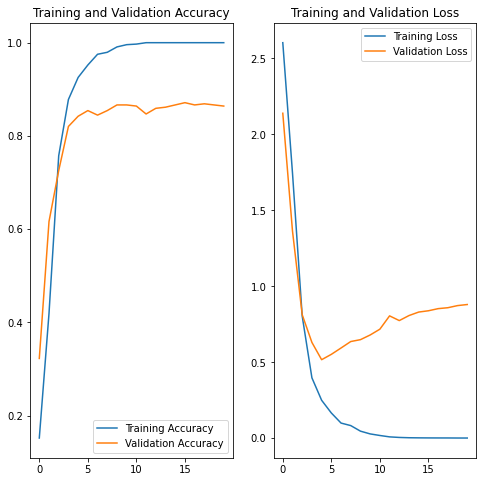

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Validacion del Modelo CNN**

In [54]:
for i in range(13):
  X_test_batch, Y_test_batch = next(iter(test_ds_nm))
  predicciones = lenet.predict(X_test_batch)
  if i==0:
    predicciones_all=predicciones
    labels_all = Y_test_batch
  else:
     predicciones_all = np.concatenate((predicciones_all,predicciones),axis=0)
     labels_all = np.concatenate((labels_all,Y_test_batch),axis=0)

1/1 [==============================] - 0s 25ms/step


In [55]:
print(predicciones_all.shape)
print(labels_all.shape)

(416, 10)
(416,)


#### **Matriz de Confusion**

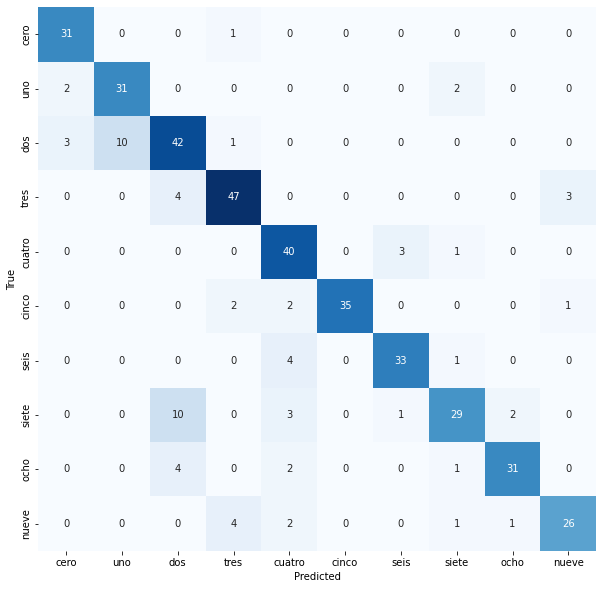

In [56]:
cm = confusion_matrix(labels_all,predicciones_all.argmax(1))
labels_cm=['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']

plt.figure(figsize=(10,10))
sns.heatmap(cm,cbar=False,xticklabels=labels_cm,yticklabels=labels_cm,fmt='d',annot=True,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Reporte Metricas del Modelo CNN**

In [60]:
print(classification_report(labels_all,predicciones_all.argmax(1), target_names=labels_cm))

              precision    recall  f1-score   support

        cero       0.86      0.97      0.91        32
         uno       0.76      0.89      0.82        35
         dos       0.70      0.75      0.72        56
        tres       0.85      0.87      0.86        54
      cuatro       0.75      0.91      0.82        44
       cinco       1.00      0.88      0.93        40
        seis       0.89      0.87      0.88        38
       siete       0.83      0.64      0.73        45
        ocho       0.91      0.82      0.86        38
       nueve       0.87      0.76      0.81        34

    accuracy                           0.83       416
   macro avg       0.84      0.84      0.84       416
weighted avg       0.84      0.83      0.83       416



## **Modelo CNN Regularizado**

### **Creacion de la Arquitectura de la Red**

In [89]:
entrada = LK.Input(shape=(180,180,3))
conv1 = LK.Conv2D(6,5,padding='same',activation = 'relu', kernel_regularizer=regularizers.L2(0.01))(entrada)
pool1 = LK.MaxPool2D((2,2),(2,2))(conv1)
conv2 = LK.Conv2D(16,5,padding='valid', activation = 'relu', kernel_regularizer=regularizers.L2(0.01))(pool1)
# drop = LK.Dropout(0.10)(conv2)
pool2 = LK.MaxPool2D((2,2),(2,2))(conv2)
flat = LK.Flatten()(pool2)
fc1 = LK.Dense(120,activation='relu',kernel_regularizer=regularizers.L2(0.01))(flat)
fc2 = LK.Dense(84,activation='relu',kernel_regularizer=regularizers.L2(0.01))(fc1)
salida = LK.Dense(10,activation='sigmoid')(fc2)
Lenet_regu = MK.Model(entrada,salida)

Lenet_regu.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 180, 180, 6)       456       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 90, 90, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 86, 86, 16)        2416      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 43, 43, 16)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 29584)             0  

### **Definicion de los Hyperparametros de la Red**

In [90]:
Lenet_regu.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

### **Entrenamiento del Modelo CNN Regularizado**

In [91]:
epochs=24
history = Lenet_regu.fit(train_ds_nm,validation_data=test_ds_nm,epochs=epochs)

Epoch 1/24
52/52 [==============================] - 3s 32ms/step - loss: 3.6590 - accuracy: 0.2642 - val_loss: 2.4897 - val_accuracy: 0.4927
Epoch 2/24
52/52 [==============================] - 2s 29ms/step - loss: 1.8851 - accuracy: 0.6648 - val_loss: 1.6081 - val_accuracy: 0.7039
Epoch 3/24
52/52 [==============================] - 2s 37ms/step - loss: 1.3185 - accuracy: 0.7909 - val_loss: 1.3963 - val_accuracy: 0.7160
Epoch 4/24
52/52 [==============================] - 2s 40ms/step - loss: 1.1859 - accuracy: 0.8079 - val_loss: 1.3654 - val_accuracy: 0.7306
Epoch 5/24
52/52 [==============================] - 2s 31ms/step - loss: 1.0302 - accuracy: 0.8461 - val_loss: 1.2145 - val_accuracy: 0.7476
Epoch 6/24
52/52 [==============================] - 2s 36ms/step - loss: 0.9502 - accuracy: 0.8461 - val_loss: 1.1534 - val_accuracy: 0.7840
Epoch 7/24
52/52 [==============================] - 2s 31ms/step - loss: 0.8665 - accuracy: 0.8782 - val_loss: 1.0789 - val_accuracy: 0.8034
Epoch 8/24
52

### **Graficos Accuracy y Loss del Modelo CNN Regularizado**

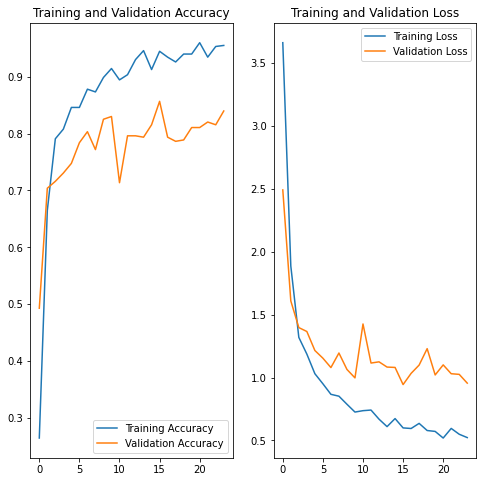

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Validacion del Modelo CNN Regularizado**

In [93]:
for i in range(13):
  X_test_batch, Y_test_batch = next(iter(test_ds_nm))
  predicciones = Lenet_regu.predict(X_test_batch)
  if i==0:
    predicciones_all=predicciones
    labels_all = Y_test_batch
  else:
     predicciones_all = np.concatenate((predicciones_all,predicciones),axis=0)
     labels_all = np.concatenate((labels_all,Y_test_batch),axis=0)

1/1 [==============================] - 0s 23ms/step


In [94]:
print(predicciones_all.shape)
print(labels_all.shape)

(416, 10)
(416,)


#### **Matriz de Confusion**

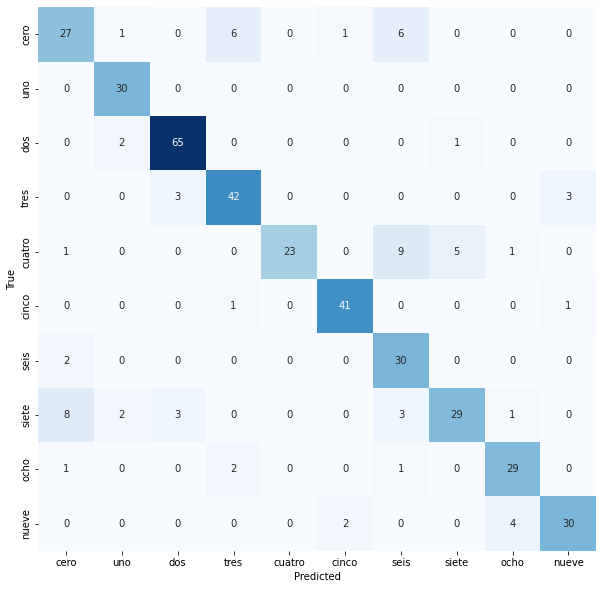

In [95]:
cm = confusion_matrix(labels_all,predicciones_all.argmax(1))
labels_cm=['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']

plt.figure(figsize=(10,10))
sns.heatmap(cm,cbar=False,xticklabels=labels_cm,yticklabels=labels_cm,fmt='d',annot=True,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Reporte Metricas del Modelo CNN Regularizado**

In [96]:
print(classification_report(labels_all,predicciones_all.argmax(1), target_names=labels_cm))

              precision    recall  f1-score   support

        cero       0.69      0.66      0.68        41
         uno       0.86      1.00      0.92        30
         dos       0.92      0.96      0.94        68
        tres       0.82      0.88      0.85        48
      cuatro       1.00      0.59      0.74        39
       cinco       0.93      0.95      0.94        43
        seis       0.61      0.94      0.74        32
       siete       0.83      0.63      0.72        46
        ocho       0.83      0.88      0.85        33
       nueve       0.88      0.83      0.86        36

    accuracy                           0.83       416
   macro avg       0.84      0.83      0.82       416
weighted avg       0.85      0.83      0.83       416



## **Conclusiones**

Como se pudo observar al realizar los tres ejercicios, se puede decir lo siguiente:

1. El modelo tradicional genera muchos erros, se vario los diferentes hyperparametros para encontrar alguna diferencia al realizar la bolsa de palabras visuales y no hubo muchas diferencias en la salida del modelo generalmente daba un accuracy entre 12% y maximo 15%.

2. Al observar las diferentes graficas del modelo CNN y el CNN regularizado, se puede notar en la grafica de loss que los datos extraidos para el entrenamiento no son representativos, esto quiere decir que los datos de entrenamiento no proporcionan suficiente informacion para aprender de las imagenes a clasificar con respecto a los datos de validacion. 

3. Al realizar varios entrenamientos de los diferentes modelos, se puede notar un poco mejor la intencion del modelo CNN regularizado de aprender, ya que genera unos valores un poco mas altos, pero a la vez oscilantes, generando una salida un poco mejor con respecto a los otros dos modelos.

4. Se Realizo tanto la regularizacion L1, L2 y Dropout, pero se determino desoues de su aplicacion que el modelo da mejores valores solo cuando se utiliza le regularizacion L2, cabe aclarar que tambien se realizaron las diferentesw formas de regularizacion en conjunto, pero igual se determino un mejor resultado solo con la utilizacion de L2